In [16]:
import numpy as np
import nengo
import nengolib
from nengo_extras.plot_spikes import cluster, merge, plot_spikes, preprocess_spikes, sample_by_variance

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Model Parameters

In [176]:
seed = 0
rng = np.random.RandomState(seed)
n_items = 6
d = 2
n_pre = 100
n_neurons = 101
n_inh = 99
dt = 0.001
t = 1.0
n_cycles = 10
T = t*n_items*n_cycles
items = nengolib.stats.ScatteredHypersphere(surface=True).sample(n_items, d, rng=rng)

### Present inputs in a cyclic pattern, with order randomized every cycle

In [177]:
def make_stim():
    stim = np.zeros((int(T/dt)+2, d))
    time = 0
    for i in range(n_cycles):
        order = np.arange(0, n_items)
        rng.shuffle(order)
        for j in range(n_items):
            for k in range(int(t/dt)):
                stim[time] = items[order[j]]
                time += 1
    return stim

stim = make_stim()

def stim_func(t, dt=0.001):
    return stim[int(t/dt)]

# 1. Generate decoders for ```pre```, use VOJA learning rule to sparsify encoders for ```target```, and use PES learning to decode ```target``` activities

In [209]:
learning_rate_voja = 3e-2
learning_rate_pes = 3e-3
synapse = nengo.Lowpass(0.01)
smooth = nengolib.DoubleExp(1e-3, 1e-1)
intercept_min = (np.dot(items, items.T) - np.eye(n_items)).flatten().max() # from Step 1 of https://www.nengo.ai/nengo/examples/learning/learn-associations.html
above_min = 0.1
intercepts = nengo.dists.Uniform(intercept_min+above_min, 1)
max_rates = nengo.dists.Uniform(20, 40)

In [210]:
with nengo.Network() as network:
    input = nengo.Node(stim_func)
    output = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
    error = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
 
    voja = nengo.Voja(learning_rate=learning_rate_voja, post_synapse=synapse)
    pes = nengo.PES(learning_rate=learning_rate_pes)

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    target = nengo.Ensemble(n_neurons, d, intercepts=intercepts, max_rates=max_rates, seed=seed+1)

    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_target = nengo.Connection(pre, target, synapse=synapse, learning_rule_type=voja)
    target_output = nengo.Connection(target, output, synapse=synapse, learning_rule_type=pes, function=lambda x: np.zeros(d))
    input_error = nengo.Connection(input, error, transform=-1, synapse=None)
    output_error = nengo.Connection(output, error, synapse=None)
    error_signal = nengo.Connection(error, target_output.learning_rule, synapse=None)
    
    p_input = nengo.Probe(input, synapse=None)
    p_target = nengo.Probe(target.neurons, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    p_encoders = nengo.Probe(pre_target.learning_rule, "scaled_encoders")
    p_decoders = nengo.Probe(target_output, "weights")
    
with nengo.Simulator(network, dt=dt) as sim:
    sim.run(T)

d_pre = sim.data[pre_target].weights
e_target = sim.data[p_encoders][-1].copy()
d_target = sim.data[p_decoders][-1].copy()
w_pre_target = np.dot(e_target, d_pre)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Confirm encoder learning has sparsified ```target```. Encoders should be clustered around the items defined in Model Parameters

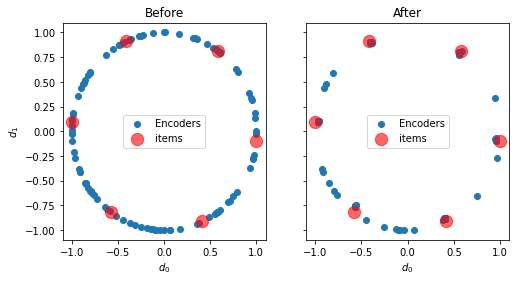

In [211]:
scale = (sim.data[target].gain / target.radius)[:, np.newaxis]
encoders_before = sim.data[p_encoders][0].copy() / scale
encoders_after = sim.data[p_encoders][-1].copy() / scale
fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((8, 4)))
ax.scatter(encoders_before[:, 0], encoders_before[:, 1], label="Encoders")
ax.scatter(items[:, 0], items[:, 1], c="red", s=150, alpha=0.6, label="items")
ax2.scatter(encoders_after[:, 0], encoders_after[:, 1], label="Encoders")
ax2.scatter(items[:, 0], items[:, 1], c="red", s=150, alpha=0.6, label="items")
ax.set(xlabel=r'$d_0$', ylabel=r'$d_1$', title='Before')
ax2.set(xlabel=r'$d_0$', title='After')
ax.legend(loc='best')
ax2.legend(loc='best')

This should also be reflected in the spike rasters

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron')]

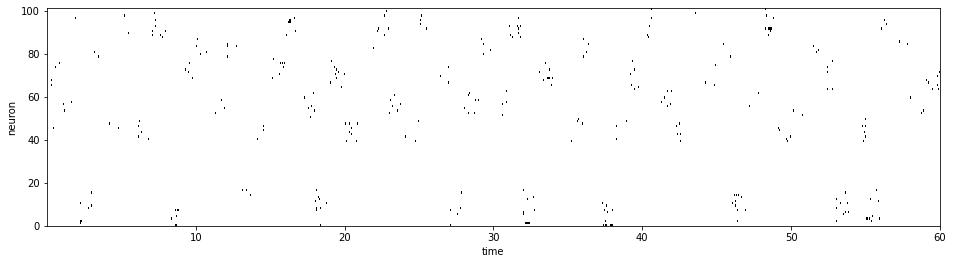

In [212]:
fig, ax = plt.subplots(figsize=((16, 4)))
plot_spikes(
    *merge(
        *cluster(
            *sample_by_variance(sim.trange(), sim.data[p_target], num=n_neurons, filter_width=0.01),
        filter_width=0.01),
    num=n_neurons))
ax.set(xlabel='time', ylabel='neuron')

Confirm that an estimate of the input ```items``` can be recovered from ```target```

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value')]

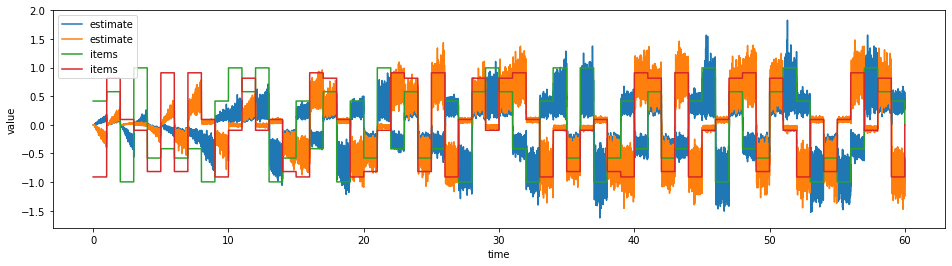

In [214]:
fig, ax = plt.subplots(figsize=((16, 4)))
ax.plot(sim.trange(), sim.data[p_output], label='estimate')
ax.plot(sim.trange(), sim.data[p_input], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value')

Test with learning removed

In [215]:
with nengo.Network() as network:
    input = nengo.Node(stim_func)
    output = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
 
    pre = nengo.Ensemble(n_pre, d, seed=seed)
    target = nengo.Ensemble(n_neurons, d, intercepts=intercepts, max_rates=max_rates, seed=seed+1)

    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_target = nengo.Connection(pre, target, synapse=synapse, solver=nengo.solvers.NoSolver(w_pre_target.T, weights=True))
    target_output = nengo.Connection(target, output, synapse=synapse, solver=nengo.solvers.NoSolver(d_target.T, weights=False))
    
    p_input = nengo.Probe(input, synapse=None)
    p_target = nengo.Probe(target.neurons, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    
with nengo.Simulator(network, dt=dt) as sim:
    sim.run(t*n_items)

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value')]

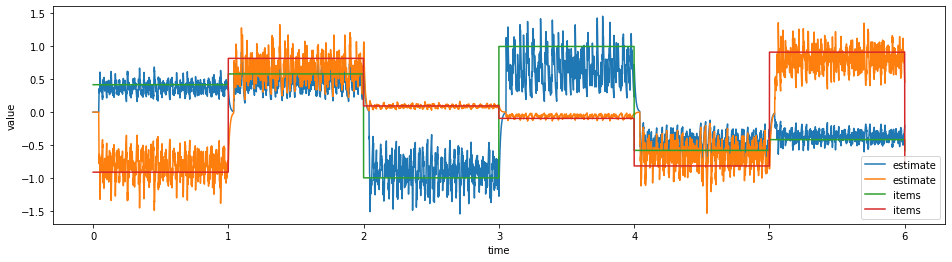

In [217]:
fig, ax = plt.subplots(figsize=((16, 4)))
ax.plot(sim.trange(), sim.data[p_output], label='estimate')
ax.plot(sim.trange(), sim.data[p_input], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value')

# 2. Define a custom node to implement a connection and a learning rule

In [220]:
class CustomLearningNode(nengo.Node):
    def __init__(self, pre, post, target, d_pre, learning_rate, exc=False, inh=False):
        self.pre = pre
        self.post = post
        self.target = target
        self.size_in = pre.n_neurons + post.n_neurons + target.n_neurons
        self.size_out = post.n_neurons
        self.d_pre = d_pre
        # 'encoders' is a connection-specific matrix used to compute weights; shape (Npre, Npost, d)
        self.e_post = np.zeros((pre.n_neurons, post.n_neurons, d_pre.shape[1]))
        self.weights = np.zeros((pre.n_neurons, post.n_neurons))
        self.learning_rate = learning_rate
        self.exc = exc
        self.inh = inh
        assert self.exc==False or self.inh==False, "Can't force excitatory and inhibitory weights"
        super().__init__(self.step, size_in=self.size_in, size_out=self.size_out)

    def step(self, t, x, update_every=10, dt=1e-3, dAmin=1e0):
        a_pre = x[:self.pre.n_neurons]  # divide inputs to node into corresponding activities
        a_post = x[self.pre.n_neurons: self.pre.n_neurons+self.post.n_neurons]
        a_target = x[self.pre.n_neurons+self.post.n_neurons:]
        if int(t/dt) % update_every == 0: # only update periodically (expensive computation)
            for post in range(self.post.n_neurons):
                dA = a_target[post] - a_post[post]
                if np.abs(dA)<dAmin: continue  # skip update if post activity is close to target activity
                for pre in range(self.pre.n_neurons):
                    for dim in range(self.d_pre.shape[1]): # each dimension of the 'encoder' is updated separately
                        sign = 1.0 if self.d_pre[pre, dim] >= 0 else -1.0 # sign ensures weight change is in the correct direction
                        dE = sign * self.learning_rate * a_pre[pre] # delta for that entry in the encoder matrix
                        self.e_post[pre, post, dim] += dA * dE
                    w = np.dot(self.d_pre[pre], self.e_post[pre, post]) # update corresponding entry in weight matrix
                    if self.exc and w < 0: w = 0 # enforce excitatory weights
                    if self.inh and w > 0: w = 0 # enforce inhibitory weights
                    self.weights[pre, post] = w # update weight matrix
        return np.dot(self.weights.T, a_pre)  # transmit weighted activity from pre to post

# 3. Train the weights on the ```pre-post``` connection so that ```post```'s activities converge to ```target```'s activities; also train readout decoders for ```post``` with PES

In [221]:
with nengo.Network() as network:
    input = nengo.Node(stim_func)
    output = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
    error = nengo.Ensemble(1, d, neuron_type=nengo.Direct())

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    target = nengo.Ensemble(n_neurons, d, intercepts=intercepts, max_rates=max_rates, seed=seed+1)
    post = nengo.Ensemble(n_neurons, d, seed=seed+2, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))

    pes = nengo.PES(learning_rate=learning_rate_pes)
    learning_node = CustomLearningNode(pre, post, target, d_pre.T, 3e-7)

    nengo.Connection(pre.neurons, learning_node[:pre.n_neurons], synapse=synapse)
    nengo.Connection(post.neurons, learning_node[pre.n_neurons: pre.n_neurons+post.n_neurons], synapse=smooth)
    nengo.Connection(target.neurons, learning_node[pre.n_neurons+post.n_neurons: ], synapse=smooth)
    nengo.Connection(learning_node, post.neurons, synapse=None)

    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_target = nengo.Connection(pre, target, synapse=synapse, solver=nengo.solvers.NoSolver(w_pre_target.T, weights=True))
    post_output = nengo.Connection(post, output, synapse=synapse, learning_rule_type=pes, solver=nengo.solvers.NoSolver(np.zeros((n_neurons, d))))  # initial decoders are zero
    input_error = nengo.Connection(input, error, transform=-1, synapse=None)
    output_error = nengo.Connection(output, error, synapse=None)
    error_signal = nengo.Connection(error, post_output.learning_rule, synapse=None)
    
    p_input = nengo.Probe(input, synapse=None)
    p_target = nengo.Probe(target.neurons, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    p_node = nengo.Probe(learning_node, synapse=None)
    p_decoders = nengo.Probe(post_output, "weights")

with nengo.Simulator(network, dt=dt) as sim:
    sim.run(T)

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/neurons.py:402: RuntimeWarning: divide by zero encountered in log1p
  max_rates = 1.0 / (self.tau_ref - self.tau_rc * np.log1p(
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengolib/signal/system.py:196: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  warnings.warn(
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [231]:
d_post = sim.data[p_decoders][-1].copy()
w_pre_post = learning_node.weights

(100, 101)


[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron 2 activity')]

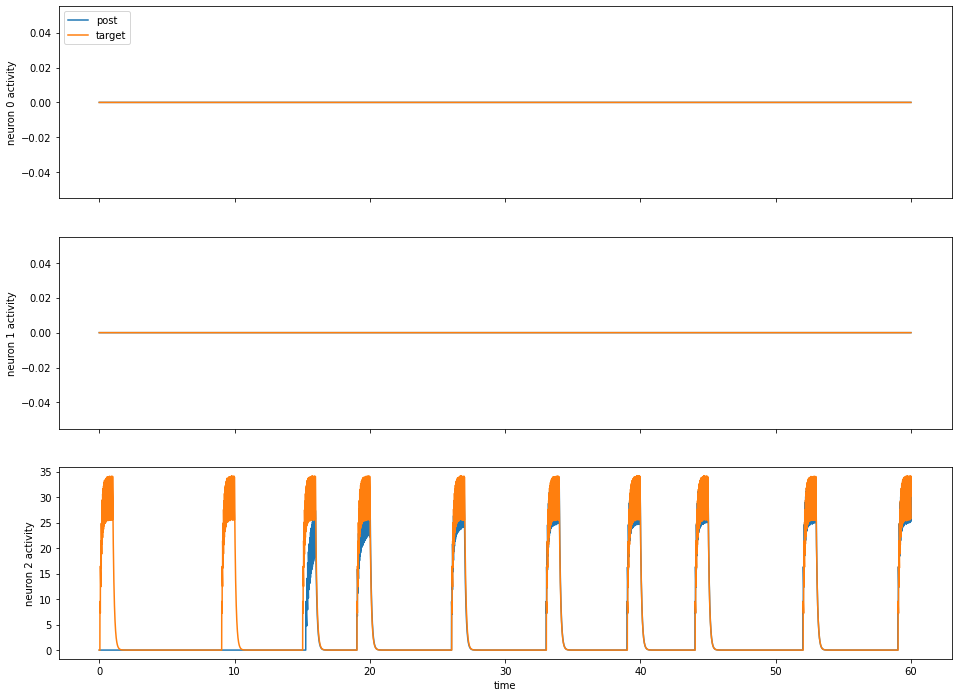

In [225]:
fig, (ax, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=((16, 12)), sharex=True)
ax.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,0], label='post')
ax.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,0], label='target')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,1], label='post')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,1], label='target')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,2], label='post')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,2], label='target')
ax.legend(loc='upper left')
ax.set(ylabel='neuron 0 activity')
ax2.set(ylabel='neuron 1 activity')
ax3.set(xlabel='time', ylabel='neuron 2 activity')

Test with learning removed

In [235]:
w_pre_post = learning_node.weights.copy()

with nengo.Network() as network:
    input = nengo.Node(stim_func)
    output = nengo.Ensemble(1, d, neuron_type=nengo.Direct())

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    post = nengo.Ensemble(n_neurons, d, seed=seed+2, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))

    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_post = nengo.Connection(pre, post, synapse=synapse, solver=nengo.solvers.NoSolver(w_pre_post, weights=True))
    post_output = nengo.Connection(post, output, synapse=synapse, solver=nengo.solvers.NoSolver(d_post.T, weights=False))
    
    p_input = nengo.Probe(input, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    
with nengo.Simulator(network, dt=dt) as sim:
    sim.run(t*n_items)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value')]

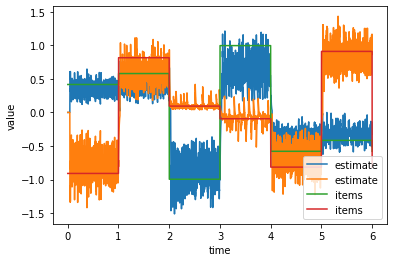

In [238]:
a_post = synapse.filt(sim.data[p_post], dt=dt)
estimate = np.dot(a_post, d_post.T)
fig, ax = plt.subplots()
ax.plot(sim.trange(), estimate, label='estimate')
ax.plot(sim.trange(), sim.data[p_input], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value')

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron')]

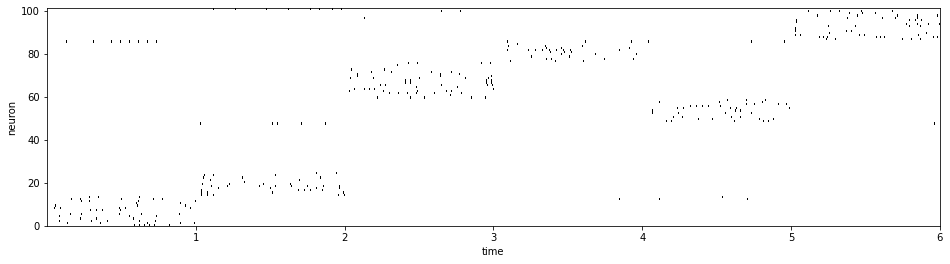

In [240]:
fig, ax = plt.subplots(figsize=((16, 4)))
plot_spikes(
    *merge(
        *cluster(
            *sample_by_variance(sim.trange(), sim.data[p_post], num=n_neurons, filter_width=0.01),
        filter_width=0.01),
    num=n_neurons))
ax.set(xlabel='time', ylabel='neuron')

# Excitatory connections only on ```pre-post```

In [15]:
with nengo.Network() as network:
    stim_items = nengo.Node(stim_func)

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    target = nengo.Ensemble(n_neurons, d, intercepts=intercepts, max_rates=max_rates, seed=seed+1)
    post = nengo.Ensemble(n_neurons, d, seed=seed+2, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))

    learning_node = CustomLearningNode(pre, post, target, d_pre.T, 3e-7, exc=True)
        
    stim_pre = nengo.Connection(stim_items, pre, synapse=None)
    pre_target = nengo.Connection(pre, target, synapse=synapse, solver=nengo.solvers.NoSolver(w_pre_target.T, weights=True))

    nengo.Connection(pre.neurons, learning_node[:pre.n_neurons], synapse=synapse)
    nengo.Connection(post.neurons, learning_node[pre.n_neurons: pre.n_neurons+post.n_neurons], synapse=smooth)
    nengo.Connection(target.neurons, learning_node[pre.n_neurons+post.n_neurons: ], synapse=smooth)
    nengo.Connection(learning_node, post.neurons, synapse=None)
    
    p_items = nengo.Probe(stim_items, synapse=None)
    p_pre = nengo.Probe(pre.neurons, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    p_target = nengo.Probe(target.neurons, synapse=None)
    p_node = nengo.Probe(learning_node, synapse=None)
    
with nengo.Simulator(network, dt=dt) as sim:
    sim.run(T)

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/neurons.py:402: RuntimeWarning: divide by zero encountered in log1p
  max_rates = 1.0 / (self.tau_ref - self.tau_rc * np.log1p(
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengolib/signal/system.py:196: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron 2 activity')]

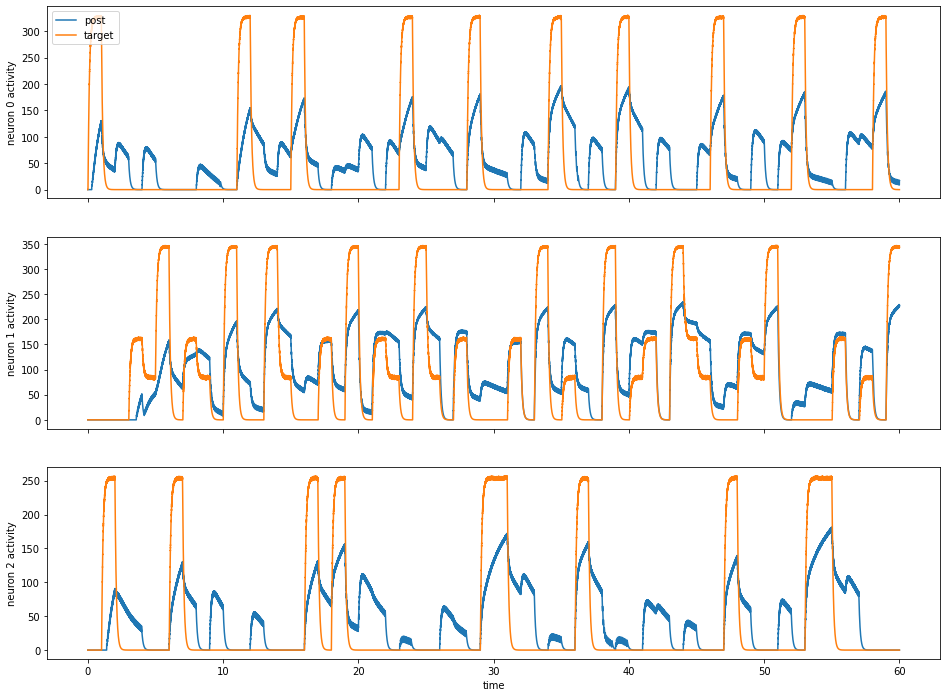

In [16]:
fig, (ax, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=((16, 12)), sharex=True)
ax.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,0], label='post')
ax.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,0], label='target')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,1], label='post')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,1], label='target')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,2], label='post')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,2], label='target')
ax.legend(loc='upper left')
ax.set(ylabel='neuron 0 activity')
ax2.set(ylabel='neuron 1 activity')
ax3.set(xlabel='time', ylabel='neuron 2 activity')

In [17]:
w_pre_post = learning_node.weights.copy()

with nengo.Network() as network:
    stim_items = nengo.Node(stim_func)

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    post = nengo.Ensemble(n_neurons, d, seed=seed+2, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))
        
    stim_pre = nengo.Connection(stim_items, pre, synapse=None)
    pre_post = nengo.Connection(pre, post, synapse=synapse, solver=nengo.solvers.NoSolver(w_pre_post, weights=True))

    p_items = nengo.Probe(stim_items, synapse=None)
    p_pre = nengo.Probe(pre.neurons, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    
with nengo.Simulator(network, dt=dt) as sim:
    sim.run(t*n_items)

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/neurons.py:402: RuntimeWarning: divide by zero encountered in log1p
  max_rates = 1.0 / (self.tau_ref - self.tau_rc * np.log1p(
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value')]

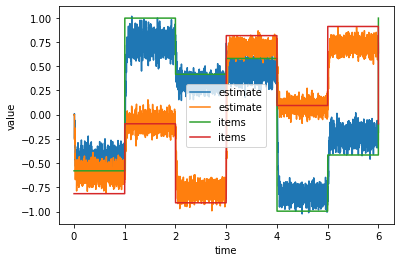

In [18]:
a_post = nengolib.Lowpass(synapse).filt(sim.data[p_post], dt=dt)
estimate = np.dot(a_post, d_target)
fig, ax = plt.subplots()
ax.plot(sim.trange(), estimate, label='estimate')
ax.plot(sim.trange(), sim.data[p_items], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value')

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron')]

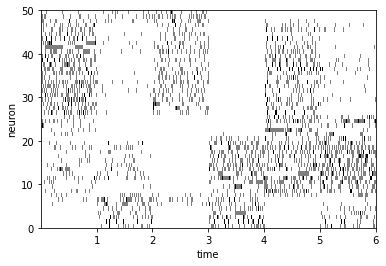

In [19]:
fig, ax = plt.subplots()
plot_spikes(*preprocess_spikes(sim.trange(), sim.data[p_post]))
ax.set(xlabel='time', ylabel='neuron')

# Add an inhibitory population, connect ```post``` to ```inh``` with a random excitation, and learn an inhibitory connection from ```inh``` to ```post``` alongside the ```pre-post``` excitatory connection

In [20]:
w_post_inh = np.random.uniform(1e-4, 1e-3, ((n_neurons, n_inh)))  # enough to generate some activity in inh

with nengo.Network() as network:
    stim_items = nengo.Node(stim_func)

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    target = nengo.Ensemble(n_neurons, d, intercepts=intercepts, max_rates=max_rates, seed=seed+1)
    post = nengo.Ensemble(n_neurons, d, seed=seed+2, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))
    inh = nengo.Ensemble(n_inh, d, seed=seed+3, gain=np.ones((n_inh)), bias=np.zeros((n_inh)))
    
    learning_node_exc = CustomLearningNode(pre, post, target, d_pre.T, 3e-7, exc=True)
    learning_node_inh = CustomLearningNode(inh, post, target, d_pre.T, 1e-7, inh=True)
        
    stim_pre = nengo.Connection(stim_items, pre, synapse=None)
    pre_target = nengo.Connection(pre, target, synapse=synapse, solver=nengo.solvers.NoSolver(w_pre_target.T, weights=True))
    post_inh = nengo.Connection(post, inh, synapse=synapse, solver=nengo.solvers.NoSolver(w_post_inh, weights=True))

    nengo.Connection(pre.neurons, learning_node_exc[:pre.n_neurons], synapse=synapse)
    nengo.Connection(post.neurons, learning_node_exc[pre.n_neurons: pre.n_neurons+post.n_neurons], synapse=smooth)
    nengo.Connection(target.neurons, learning_node_exc[pre.n_neurons+post.n_neurons: ], synapse=smooth)
    nengo.Connection(learning_node_exc, post.neurons, synapse=None)
    
    nengo.Connection(inh.neurons, learning_node_inh[:inh.n_neurons], synapse=synapse)
    nengo.Connection(post.neurons, learning_node_inh[inh.n_neurons: inh.n_neurons+post.n_neurons], synapse=smooth)
    nengo.Connection(target.neurons, learning_node_inh[inh.n_neurons+post.n_neurons: ], synapse=smooth)
    nengo.Connection(learning_node_inh, post.neurons, synapse=None)
    
    p_items = nengo.Probe(stim_items, synapse=None)
    p_pre = nengo.Probe(pre.neurons, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    p_inh = nengo.Probe(inh.neurons, synapse=None)
    p_target = nengo.Probe(target.neurons, synapse=None)
    p_node_exc = nengo.Probe(learning_node_exc, synapse=None)
    p_node_inh = nengo.Probe(learning_node_inh, synapse=None)
    
with nengo.Simulator(network, dt=dt) as sim:
    sim.run(T)

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/neurons.py:402: RuntimeWarning: divide by zero encountered in log1p
  max_rates = 1.0 / (self.tau_ref - self.tau_rc * np.log1p(
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengolib/signal/system.py:196: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron 2 activity')]

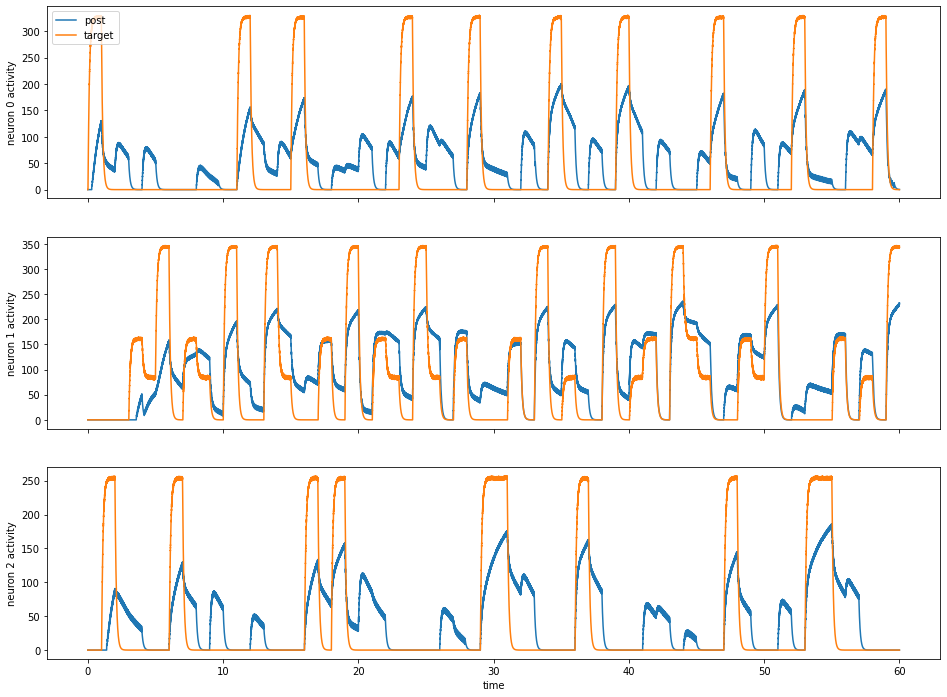

In [21]:
fig, (ax, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=((16, 12)), sharex=True)
ax.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,0], label='post')
ax.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,0], label='target')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,1], label='post')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,1], label='target')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,2], label='post')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,2], label='target')
ax.legend(loc='upper left')
ax.set(ylabel='neuron 0 activity')
ax2.set(ylabel='neuron 1 activity')
ax3.set(xlabel='time', ylabel='neuron 2 activity')

In [25]:
w_inh_post = learning_node_inh.weights
w_pre_post = learning_node_exc.weights

with nengo.Network() as network:
    stim_items = nengo.Node(stim_func)

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    post = nengo.Ensemble(n_neurons, d, seed=seed+2, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))
    inh = nengo.Ensemble(n_inh, d, seed=seed+3, gain=np.ones((n_inh)), bias=np.zeros((n_inh)))
        
    stim_pre = nengo.Connection(stim_items, pre, synapse=None)
    pre_post = nengo.Connection(pre, post, synapse=synapse, solver=nengo.solvers.NoSolver(w_pre_post, weights=True))
    post_inh = nengo.Connection(post, inh, synapse=synapse, solver=nengo.solvers.NoSolver(w_post_inh, weights=True))
    inh_post = nengo.Connection(inh, post, synapse=synapse, solver=nengo.solvers.NoSolver(w_inh_post, weights=True))
    
    p_items = nengo.Probe(stim_items, synapse=None)
    p_pre = nengo.Probe(pre.neurons, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    p_inh = nengo.Probe(inh.neurons, synapse=None)
    
with nengo.Simulator(network, dt=dt) as sim:
    sim.run(t*n_items)

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/neurons.py:402: RuntimeWarning: divide by zero encountered in log1p
  max_rates = 1.0 / (self.tau_ref - self.tau_rc * np.log1p(
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value')]

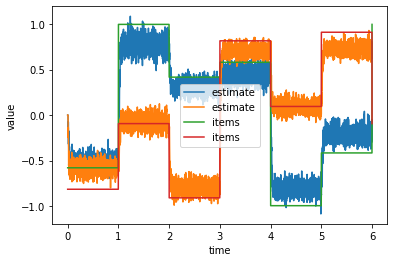

In [26]:
a_post = nengolib.Lowpass(synapse).filt(sim.data[p_post], dt=dt)
estimate = np.dot(a_post, d_target)
fig, ax = plt.subplots()
ax.plot(sim.trange(), estimate, label='estimate')
ax.plot(sim.trange(), sim.data[p_items], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value')

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron')]

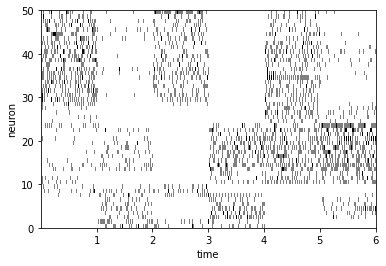

In [27]:
fig, ax = plt.subplots()
plot_spikes(*preprocess_spikes(sim.trange(), sim.data[p_post]))
ax.set(xlabel='time', ylabel='neuron')

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron')]

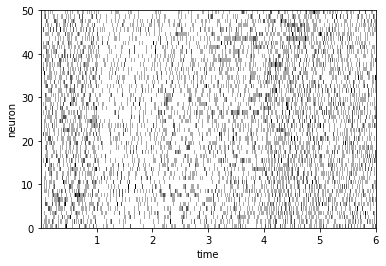

In [28]:
fig, ax = plt.subplots()
plot_spikes(*preprocess_spikes(sim.trange(), sim.data[p_inh]))
ax.set(xlabel='time', ylabel='neuron')

# 4. Specify an adaptive neuron type for ```post```. Use ```DoubleExp``` synapses with AMPA parameters for excitatory connections from ```pre``` to ```post``` 

In [242]:
AMPA = nengolib.synapses.DoubleExp(0.55e-3, 2.2e-3)
post_type = nengo.Izhikevich()  # todo: find biological parameters

In [245]:
with nengo.Network() as network:
    input = nengo.Node(stim_func)
    output = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
    error = nengo.Ensemble(1, d, neuron_type=nengo.Direct())

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    target = nengo.Ensemble(n_neurons, d, intercepts=intercepts, max_rates=max_rates, seed=seed+1)
    post = nengo.Ensemble(n_neurons, d, neuron_type=post_type, seed=seed+2, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))

    pes = nengo.PES(learning_rate=learning_rate_pes)
    learning_node = CustomLearningNode(pre, post, target, d_pre.T, 3e-7, exc=True)

    nengo.Connection(pre.neurons, learning_node[:pre.n_neurons], synapse=AMPA)
    nengo.Connection(post.neurons, learning_node[pre.n_neurons: pre.n_neurons+post.n_neurons], synapse=smooth)
    nengo.Connection(target.neurons, learning_node[pre.n_neurons+post.n_neurons: ], synapse=smooth)
    nengo.Connection(learning_node, post.neurons, synapse=None)

    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_target = nengo.Connection(pre, target, synapse=synapse, solver=nengo.solvers.NoSolver(w_pre_target.T, weights=True))
    post_output = nengo.Connection(post, output, synapse=AMPA, learning_rule_type=pes, solver=nengo.solvers.NoSolver(np.zeros((n_neurons, d))))  # initial decoders are zero
    input_error = nengo.Connection(input, error, transform=-1, synapse=None)
    output_error = nengo.Connection(output, error, synapse=None)
    error_signal = nengo.Connection(error, post_output.learning_rule, synapse=None)
    
    p_input = nengo.Probe(input, synapse=None)
    p_target = nengo.Probe(target.neurons, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    p_node = nengo.Probe(learning_node, synapse=None)
    p_decoders = nengo.Probe(post_output, "weights")

with nengo.Simulator(network, dt=dt) as sim:
    sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [246]:
d_post = sim.data[p_decoders][-1].copy()
w_pre_post = learning_node.weights

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron 2 activity')]

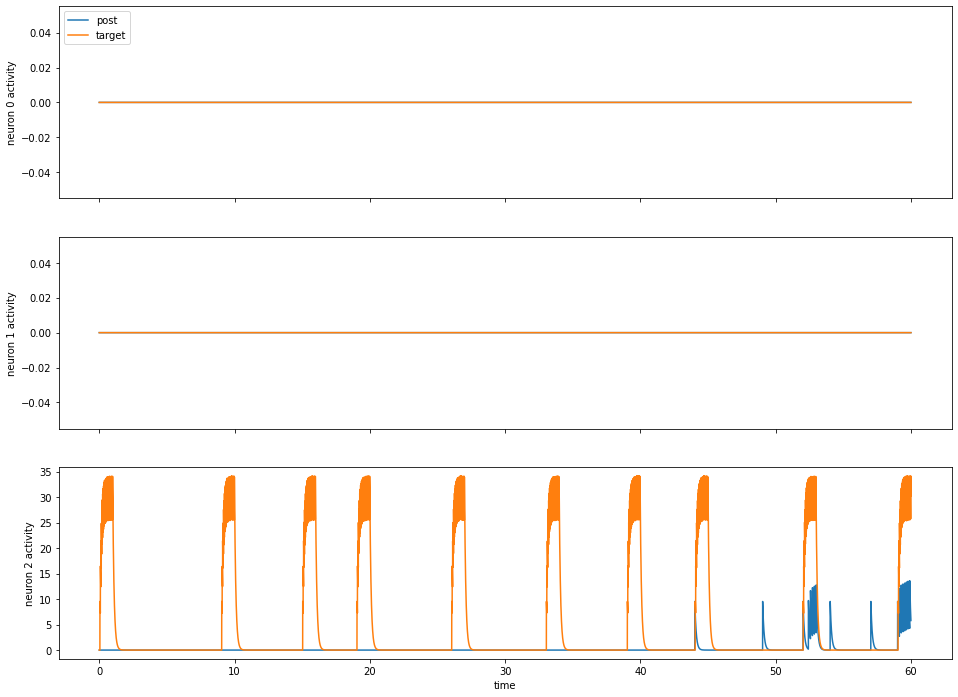

In [247]:
fig, (ax, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=((16, 12)), sharex=True)
ax.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,0], label='post')
ax.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,0], label='target')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,1], label='post')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,1], label='target')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,2], label='post')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,2], label='target')
ax.legend(loc='upper left')
ax.set(ylabel='neuron 0 activity')
ax2.set(ylabel='neuron 1 activity')
ax3.set(xlabel='time', ylabel='neuron 2 activity')

Test with learning removed

In [248]:
with nengo.Network() as network:
    input = nengo.Node(stim_func)
    output = nengo.Ensemble(1, d, neuron_type=nengo.Direct())

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    post = nengo.Ensemble(n_neurons, d, neuron_type=post_type, seed=seed+2, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))

    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_post = nengo.Connection(pre, post, synapse=AMPA, solver=nengo.solvers.NoSolver(w_pre_post, weights=True))
    post_output = nengo.Connection(post, output, synapse=AMPA, solver=nengo.solvers.NoSolver(d_post.T, weights=False))
    
    p_input = nengo.Probe(input, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    
with nengo.Simulator(network, dt=dt) as sim:
    sim.run(t*n_items)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengolib/signal/system.py:196: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value')]

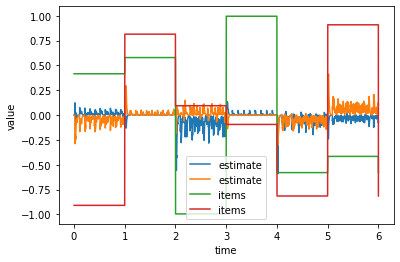

In [249]:
a_post = synapse.filt(sim.data[p_post], dt=dt)
estimate = np.dot(a_post, d_post.T)
fig, ax = plt.subplots()
ax.plot(sim.trange(), estimate, label='estimate')
ax.plot(sim.trange(), sim.data[p_input], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value')

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron')]

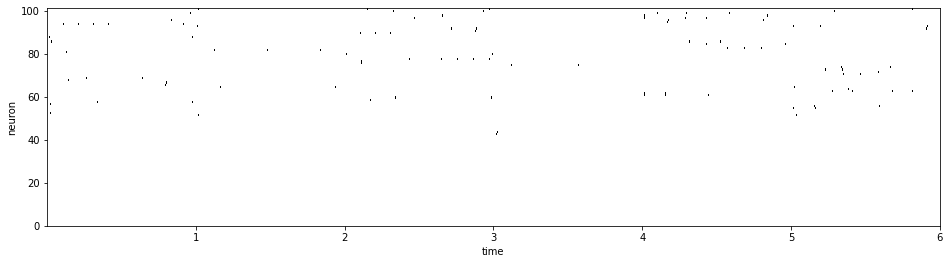

In [250]:
fig, ax = plt.subplots(figsize=((16, 4)))
plot_spikes(
    *merge(
        *cluster(
            *sample_by_variance(sim.trange(), sim.data[p_post], num=n_neurons, filter_width=0.01),
        filter_width=0.01),
    num=n_neurons))
ax.set(xlabel='time', ylabel='neuron')

# 5. Disallow "unlearing" in excitatory connection (weight can only increase, from e.g. the formation of new synapses). Use local inhibition to fill the role of negative weights. Implement random local connectivity between ```post``` and a new inhibitory population ```inh``` with NMDA synapses. Learn the connection from ```inh``` back to ```post``` at the same time as the ```pre-post``` connection, but enforce negative weights and no "unlearning".

In [ ]:
NMDA = nengolib.synapses.DoubleExp(10.6e-3, 285e-3)
GABA = nengolib.synapses.DoubleExp(0.5e-3, 1.5e-3)
AMPA = nengolib.synapses.DoubleExp(0.55e-3, 2.2e-3)
smooth = nengolib.synapses.DoubleExp(1e-3, 2e-1)
post_neuron = nengo.AdaptiveLIF()  # todo: find biological parameters
inh_neuron = nengo.Izhikevich()  # todo: find biological parameters
w_post_inh = np.random.uniform(1e-3, 9e-3, ((n_neurons, n_inh)))  # enough to generate some activity in inh
max_rates = nengo.dists.Uniform(20, 40)

intercept_mean = (np.dot(items, items.T) - np.eye(n_items)).flatten().max()
intercept_std = 1e-1
intercepts = rng.normal(intercept_mean, intercept_std, n_neurons)